In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

import os
cwd=os.getcwd()
os.chdir(cwd[:len('StableRemaster')+cwd.find('StableRemaster')])

from tqdm import tqdm

In [2]:
from src import *

In [3]:
DATA_PATH = './data/02_scenes/'

In [4]:
def display_masked_image(im, mask):
    new_im = cv2.bitwise_and(im , im , mask = mask)
    plt.imshow(new_im)

def trim_black(frame,mask):
    #print(frame.shape)
    if not np.any(frame):
        print('fuck')
        return frame,mask
    
    it_bottom = -1
    while not(np.any(frame[it_bottom,:,:])):
        it_bottom-=1
    
    it_top = 0
    while not(np.any(frame[it_top,:,:])):
        it_top+=1
    
    it_right = -1
    while not(np.any(frame[:,it_right,:])):
        it_right-=1
    
    it_left = 0
    while not(np.any(frame[:,it_left,:])):
        it_left+=1
    
    it_bottom = frame.shape[0]+it_bottom+1
    it_right = frame.shape[1]+it_right+1
    
    frame = frame[it_top:it_bottom,it_left:it_right,:]
    mask = mask[it_top:it_bottom,it_left:it_right]
    
    return frame,mask
    
def get_padding(x_offset,y_offset,x_pad_size,y_pad_size):
    x_pad=None
    y_pad=None
    
    if x_offset<=0:
        x_pad = (0,x_pad_size)
    else:
        x_pad = (x_pad_size,0)
    if y_offset<=0:
        y_pad = (0,y_pad_size)
    else:
        y_pad = (y_pad_size,0)

    return x_pad,y_pad
    
def stitch_images(image1, image2, mask1, mask2, scale=1):
    # Detect features and keypoints using SIFT
    sift = cv2.SIFT_create()
    #display_masked_image(image1,mask1)
    keypoints1, descriptors1 = sift.detectAndCompute(image1, mask1)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, mask2)

    # Match the features using FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    # Filter good matches using the ratio test
    good_matches = []
    for pair in matches:
        if len(pair) == 2:
            m, n = pair
            if m.distance < 0.5 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 5:  # Minimum number of matches required for homography
        print("Not enough good matches found to stitch the images.")
        print("# of good matches:", len(good_matches))
        return image1, mask1, np.array([[0,0,0],[0,0,0]])

    # Extract the matched points
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute the Affine Transformation using RANSAC
    M, _ = cv2.estimateAffine2D(src_pts, dst_pts, cv2.RANSAC)
    M_o = np.copy(M)
    x_offset = M[0,2]
    y_offset = M[1,2]
    
    x_pad_size = int(np.floor(abs(x_offset)))
    y_pad_size = int(np.floor(abs(y_offset)))
    
    #if(abs(x_offset)>1 or abs(y_offset)>1):
        #print(y_offset,x_offset)
    
    # Warp image2 using the computed homography
    h, w = image1.shape[:2]
    
    h += y_pad_size
    w += x_pad_size
    
    if x_offset<0:
        #make affine transformation positive
        M[0,2]+=x_pad_size
    if y_offset<0:
        #make affine transformation positive
        M[1,2]+=y_pad_size
    #h = image1.shape[0]+image2.shape[0]
    #w = image1.shape[1]+image2.shape[1]
    warped_image2 = cv2.warpAffine(image2, M, (w, h))
    warped_mask = cv2.warpAffine(mask2,M, (w,h))
    
    #return M, warped_image2
    #return image2,warped_image2
    x_pad, y_pad = get_padding(x_offset,y_offset,x_pad_size, y_pad_size)
    
    padded_image1 = np.pad(image1, (y_pad,x_pad,(0,0)),'constant',constant_values=(0,0))
    padded_mask1 = np.pad(mask1, (y_pad,x_pad),'constant',constant_values=(0,0))
    
    #print(padded_mask1.shape,warped_mask.shape)
    #stitched_mask = np.any([mask1,warped_mask],axis=0).astype('uint8')
    stitched_mask = np.any([padded_mask1,warped_mask],axis=0).astype('uint8')
    
    masked_im1 = cv2.bitwise_and(padded_image1 , padded_image1 , mask = padded_mask1).astype('uint8')
    masked_im2 = cv2.bitwise_and(warped_image2 , warped_image2 , mask = warped_mask).astype('uint8')
    #masked_im1 = cv2.bitwise_and(image1 , image1 , mask = mask1).astype('uint8')
    #masked_im2 = cv2.bitwise_and(warped_image2 , warped_image2 , mask = warped_mask).astype('uint8')
    
    warped_mask = warped_mask/scale
    masked_im2 = masked_im2/scale
    
    mask_count = np.sum([padded_mask1,warped_mask],axis=0)
    #mask_count = np.sum([mask1,warped_mask],axis=0)
    mask_count[np.where(mask_count==0)]=1
    im_sum = np.sum([masked_im1,masked_im2],axis=0)
    
    averaged_image = (im_sum/np.expand_dims(mask_count, axis=-1)).astype('uint8')
    
    return averaged_image, stitched_mask, M_o


def stitch_multiple(images, masks):
    if len(images) < 2:
        raise ValueError("At least two images are required for stitching.")
    if len(images)!=len(masks):
        raise ValueError('Number of Masks and Images must match')
    stitched_image = images[0]
    stitched_mask = masks[0]
    Ms = [np.array([[1,0,0],[0,1,0]])]
    for i in tqdm(range(1, len(images))):
        stitched_image, stitched_mask, M = stitch_images(stitched_image, images[i], stitched_mask, masks[i],scale=i)
        #print(stitched_image.shape)
        stitched_image, stitched_mask = trim_black(stitched_image, stitched_mask)
        #print(stitched_image.shape)
        Ms.append(M)
    Ms = np.array(Ms)
    
    y_translate = np.min(Ms[:,1,2])
    x_translate = np.min(Ms[:,0,2])
    if y_translate<0:
        Ms[:,1,2]+=abs(y_translate)
    if x_translate<0:
        Ms[:,0,2]+=abs(x_translate)

    return stitched_image,stitched_mask, Ms

In [5]:
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

In [6]:
segmenter = background_segmentation_loader()

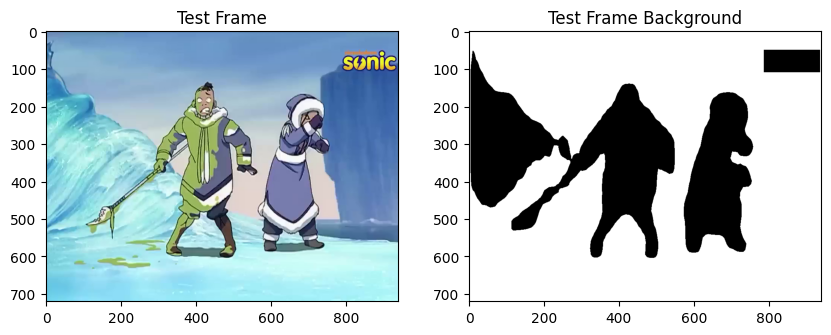

In [7]:
test_frame1 = frames[0]

bg1,bg_mask1 = segmenter(test_frame1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask1, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

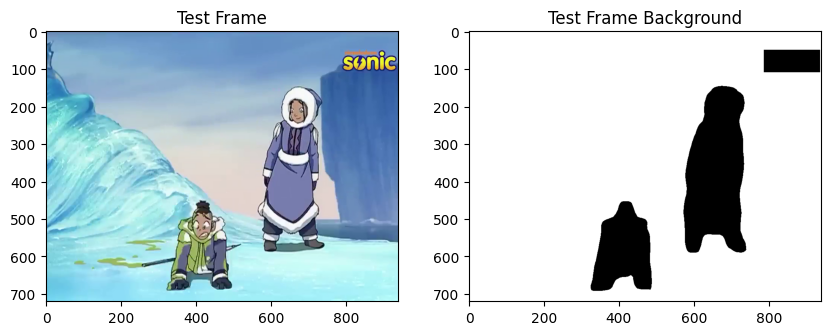

In [8]:
test_frame2 = frames[70]

bg2, bg_mask2 = segmenter(test_frame2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame2, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask2, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

In [28]:
stitched_im, stitched_mask, M = stitch_images(test_frame1, test_frame2, bg_mask1, bg_mask2)

In [29]:
masks = []
bgs = []
for frame in tqdm(frames):
    bg, bg_mask = segmenter(frame,mask_conf=0.2,cat_conf=0.4)
    masks.append(bg_mask)
    bgs.append(bg)

100%|██████████████████████████████████████| 132/132 [4:53:17<00:00, 133.31s/it]


In [37]:
total_bg, total_mask, Ms = stitch_multiple(frames, masks)

 88%|███████████████████████████████████▉     | 115/131 [00:29<00:03,  4.40it/s]

Not enough good matches found to stitch the images.
# of good matches: 4
Not enough good matches found to stitch the images.
# of good matches: 4


 93%|██████████████████████████████████████▏  | 122/131 [00:31<00:02,  4.21it/s]

Not enough good matches found to stitch the images.
# of good matches: 4


100%|█████████████████████████████████████████| 131/131 [00:33<00:00,  3.86it/s]


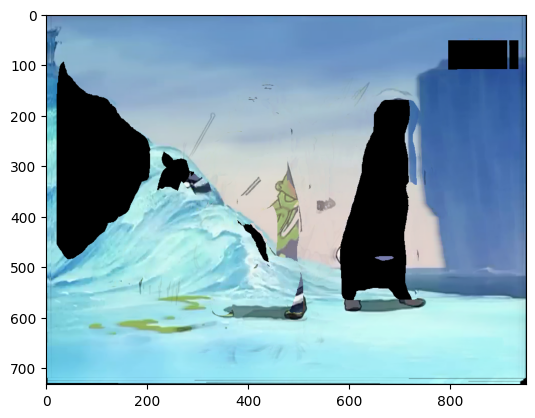

In [38]:
plt.imshow(total_bg,'gray')

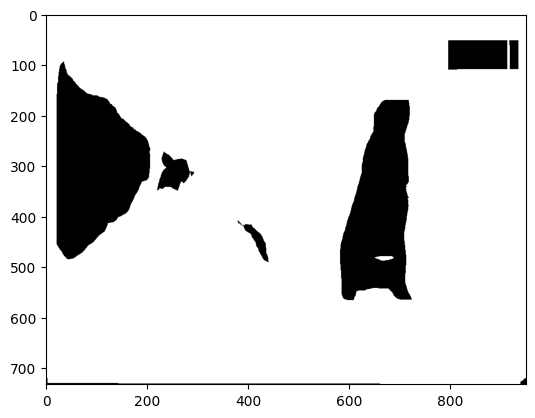

In [39]:
plt.imshow(total_mask,'gray')

In [9]:
def get_new_window_padding(frame_shape):
    new_width = frame_shape[0]*16//9
    padding = (new_width-frame_shape[1])//2
    return padding

def get_new_window_mask(frame_shape):
    new_width = frame_shape[0]*16//9
    new_window_mask = np.ones((frame_shape[0],new_width))
    left_bar = (new_width-frame_shape[1])//2
    right_bar = new_width-left_bar
    new_window_mask[:,left_bar:right_bar]=0
    return new_window_mask

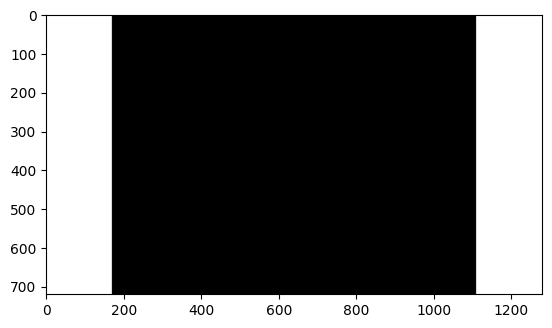

In [10]:
new_window_mask=get_new_window_mask(test_frame1.shape)
plt.imshow(new_window_mask,'gray')

In [11]:
if torch.cuda.is_available():
    print('Device: CUDA')
    print('-'*30)
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        revision="fp16",
        torch_dtype=torch.float16,
    )
    device = torch.device('cuda')
else:
    print('Device: CPU')
    print('-'*30)
    pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting",)
    device = torch.device('cpu')

pipe.to(device)

Device: CPU
------------------------------


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/nathan.paull/opt/anaconda3/envs/stare/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.13.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [12]:
m1 = get_new_window_mask(test_frame1.shape)*255
t1 = np.pad(test_frame1, ((0,0),(170,170),(0,0)),'constant',constant_values=(0,0))
t1 = Image.fromarray(t1).convert("RGB")
m1 = Image.fromarray(m1).convert("RGB")

In [ ]:
n1 = pipe(prompt='',image=t1, mask_image=m1,height=720,width=1280).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
plt.imshow(n1)

In [115]:
def resample_frame(frame,mask,M):
    global total_bg, total_mask
    #need to pad total_bg and total_mask as well
    mask = (mask*-1+1).astype('uint8')
    frame, mask = get_pad_frame(frame,mask)
    # transform frame and mask?
    h, w = total_bg.shape[:2]
    h0,w0 = frame.shape[:2]
    t_frame = cv2.warpAffine(frame, M, (w,h))
    t_mask = cv2.warpAffine(mask, M, (w,h))
    # and mask w/ total_mask, then send to stable diffusion
    sd_mask = cv2.bitwise_and(t_mask , t_mask , mask = total_mask).astype('uint8')
    #send to stable diffusion w/ total_bg (only if the mask isn't all 0s?)
    
    #return t_frame,t_mask,sd_mask
    if np.any(sd_mask):
        print(total_bg.shape,sd_mask.shape)
        total_bg2 = pipe(prompt='',image=total_bg, mask_image=sd_mask).images[0]
    #total_mask = cv2.bitwise_xor(total_mask, sd_mask)
    sd_mask = (-1*sd_mask+1).astype('uint8')
    total_mask2 = cv2.bitwise_and(total_mask,sd_mask)
    # sample new total_bg using mask
    sampled_pixels = cv2.bitwise_and(total_bg2 , total_bg2 , mask = t_mask).astype('uint8')
    
    return total_bg2, sampled_pixels, total_mask2
    # add this sample to frame
    new_frame = np.sum([sampled_pixels, t_frame],axis=0)
    # reverse affine transformation
    M_inv = get_inv_trans(M)
    new_frame = cv2.warpAffine(new_frame, M_inv, (w0,h0))
    # return frame alone
    return new_frame

def get_pad_frame(frame, mask):
    padding = get_new_window_padding(frame.shape)
    padded_frame = np.pad(frame, 
                             ((0,0),(padding,padding),(0,0)),
                             'constant',
                             constant_values=0)
    padded_mask = np.pad(mask, 
                             ((0,0),(padding,padding)),
                             'constant',
                             constant_values=1)
    return padded_frame, padded_mask

def prepare_total_resample(total_bg, total_mask, padding):
    total_mask = (total_mask*-1+1).astype('uint8')
    
    padded_bg = np.pad(total_bg, 
                             ((0,0),(padding,padding),(0,0)),
                             'constant',
                             constant_values=0)
    padded_mask = np.pad(total_mask, 
                             ((0,0),(padding,padding)),
                             'constant',
                             constant_values=1)
    return padded_bg, padded_mask

def get_inv_trans(M):
    R_inv = np.copy(M[:,:2]).T
    
    T_inv = np.zeros([2,1]) 
    T_inv[0,0] = -1*M[0,2]*M[0,0] - M[1,2]*M[0,1]
    T_inv[1,0] = -1*M[0,2]*M[0,0] + M[1,2]*M[0,1]
    
    M_inv = np.concatenate([R_inv,T_inv],axis=1)
    
    return M_inv

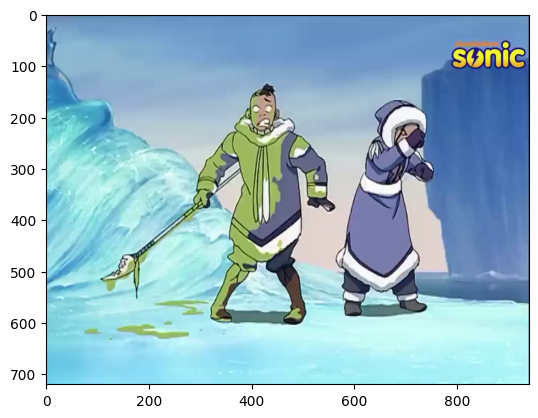

In [70]:
plt.imshow(test_frame1)

In [91]:
t1,t2=get_pad_frame(test_frame1,bg_mask1)

170


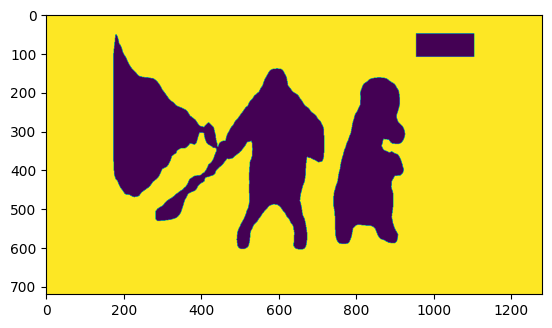

In [92]:
plt.imshow(t2)

In [45]:
Ms[0]

array([[ 1.        ,  0.        , 13.35897218],
       [ 0.        ,  1.        ,  9.1560906 ]])

In [ ]:
raise Exception

In [116]:
t_bg,s_px,t_m = resample_frame(test_frame1,bg_mask1, Ms[0])

(732, 1290, 3) (732, 1290)


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 91 for tensor number 2 in the list.

In [ ]:
plt.imshow(t_bg,'gray')

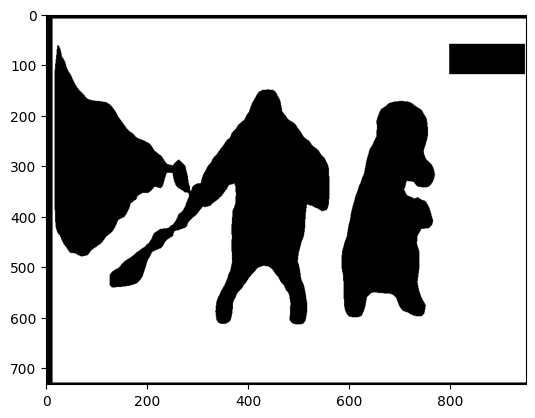

In [99]:
plt.imshow(t_mask,'gray')

In [95]:
padding = get_new_window_padding(test_frame1.shape)
total_bg,total_mask = prepare_total_resample(total_bg,total_mask,padding)

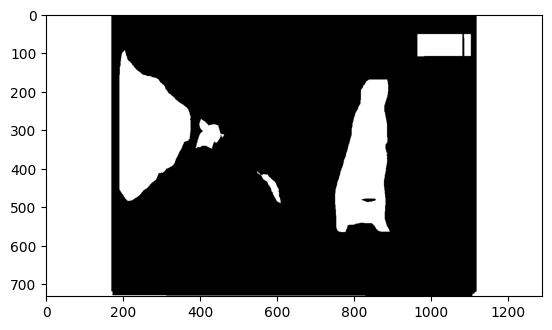

In [98]:
plt.imshow(total_mask,'gray')

In [ ]:
new_frame1 = resample_frame(test_frame1,bg_mask1, Ms[0])

In [ ]:
plt.imshow(new_frame1)